In [4]:
import pandas as pd
import numpy as np
import re
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

In [5]:
Data_path='/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv'
df = pd.read_csv(Data_path)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [7]:
df['sentiment'].unique()

array(['positive', 'negative'], dtype=object)

Text(0.5, 1.0, 'Sentiment Field Distribution\n25000\n25000')

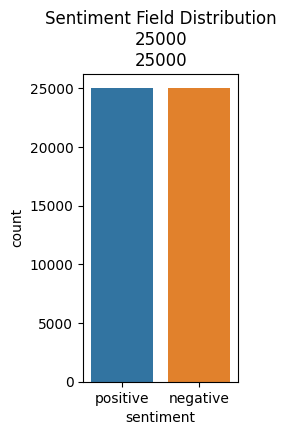

In [8]:
val_count=df["sentiment"].value_counts()
plt.figure(figsize= (2,4))
sns.countplot(data = df, x= 'sentiment')
plt.title(f'Sentiment Field Distribution\n{val_count.to_string(index=False, header=None)}')

## Mapping positive->1, Negative->0

In [9]:
df.loc[df["sentiment"] == 'positive', "sentiment"] = 1
df.loc[df["sentiment"] == 'negative', "sentiment"] = 0

In [10]:
df['sentiment'].unique()

array([1, 0], dtype=object)

## Regular Expression to clean text by removing urls, emojis, html tags and punctuations.

In [11]:
stop_words = set(stopwords.words('english'))
def clean_text(sentence):
    # Removing URLS
    sentence = re.sub(r"https?://\S+|www\.\S+"," ",sentence)
    
    # Removing html tags
    sentence = re.sub(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});"," ",sentence)
    
    # Removing the Punctuation
    sentence = re.sub(r"[^\w\s]", " ", sentence)
        
    # Removing words that have numbers 
    sentence = re.sub(r"\w*\d\w*", " ", sentence)
        
    # Removing Digits 
    sentence = re.sub(r"[0-9]+", " ", sentence)
        
    # Cleaning white spaces
    sentence = re.sub(r"\s+", " ", sentence).strip()
        
    sentence = sentence.lower()
    # Check stop words
    tokens = []
    for token in sentence.split():
        if token not in stop_words:
            tokens.append(token)
    return " ".join(tokens)

In [12]:
df.loc[:, 'review'] = df['review'].apply(clean_text)

In [13]:
df.head()

,review,sentiment
0,one reviewers mentioned watching oz episode ho...,1
1,wonderful little production filming technique ...,1
2,thought wonderful way spend time hot summer we...,1
3,basically family little boy jake thinks zombie...,0
4,petter mattei love time money visually stunnin...,1


In [14]:
df['review'][1]

'wonderful little production filming technique unassuming old time bbc fashion gives comforting sometimes discomforting sense realism entire piece actors extremely well chosen michael sheen got polari voices pat truly see seamless editing guided references williams diary entries well worth watching terrificly written performed piece masterful production one great master comedy life realism really comes home little things fantasy guard rather use traditional dream techniques remains solid disappears plays knowledge senses particularly scenes concerning orton halliwell sets particularly flat halliwell murals decorating every surface terribly well done'

In [15]:
X = df['review']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

print("Train Data size:", len(X_train), len(y_train))
print("Test Data size", len(X_test), len(y_test))

Train Data size: 40000 40000
Test Data size 10000 10000


In [16]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convert text to sequences of integers
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


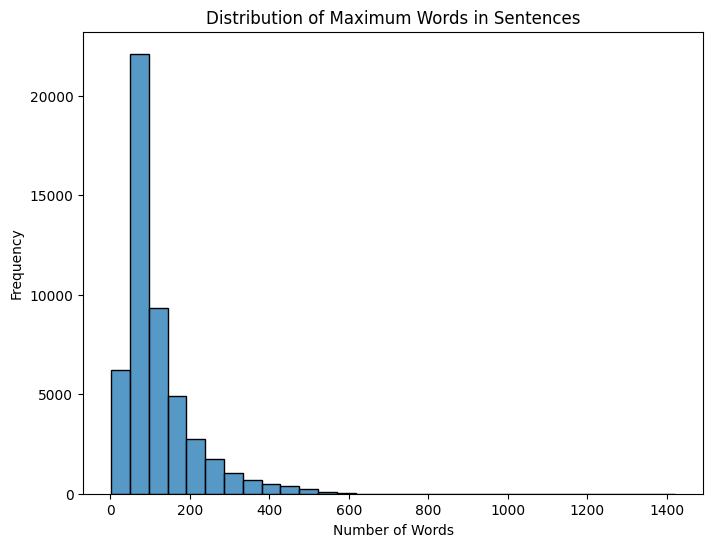

In [17]:
max_words = df['review'].apply(lambda x: len(x.split()))

# Plotting the distribution of the maximum number of words in sentences
plt.figure(figsize=(8, 6))
sns.histplot(max_words, bins=30)
plt.title('Distribution of Maximum Words in Sentences')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

#### Hyperparameters 

In [18]:
max_len = 200  # Maximum words in each sequence.
batch_size=512

#### Padding

In [19]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [20]:
vocabulary_size = len(tokenizer.word_index)
vocabulary_size

91086

In [21]:
model = Sequential()
model.add(Embedding(input_dim=vocabulary_size, output_dim=128))
model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [22]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

y_train = y_train.astype('int32')
y_test = y_test.astype('int32')

In [23]:
history=model.fit(X_train, y_train, epochs=5,validation_data=(X_test, y_test),batch_size=batch_size)

Epoch 1/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.5153 - loss: 0.6926 - val_accuracy: 0.5594 - val_loss: 0.6878
Epoch 2/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.6398 - loss: 0.6605 - val_accuracy: 0.8348 - val_loss: 0.4454
Epoch 3/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.8493 - loss: 0.4182 - val_accuracy: 0.8705 - val_loss: 0.3192
Epoch 4/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.8951 - loss: 0.2937 - val_accuracy: 0.8763 - val_loss: 0.2974
Epoch 5/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.9107 - loss: 0.2516 - val_accuracy: 0.8875 - val_loss: 0.2727


In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 128)       │    11,659,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,421,701 (135.12 MB)

 Trainable params: 11,807,233 (45.04 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 23,614,468 (90.08 MB)

313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 72ms/step


Text(95.72222222222221, 0.5, 'Truth')

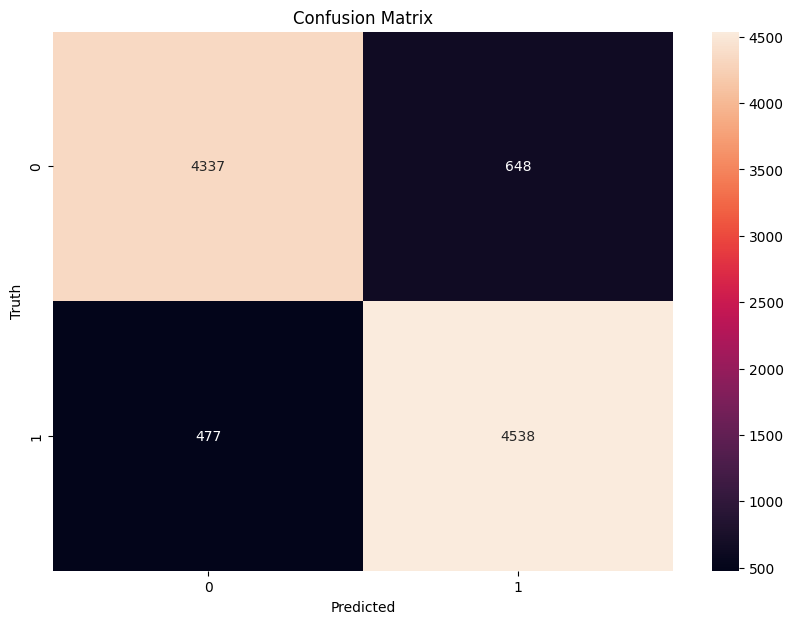

In [25]:
y_pred = model.predict(X_test)
y_pred_rounded = np.round(y_pred)
cm = tf.math.confusion_matrix(labels=y_test,predictions=y_pred_rounded)


plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [26]:
print("Classification Report: \n", classification_report(y_test, y_pred_rounded))

Classification Report: 
               precision    recall  f1-score   support

           0       0.90      0.87      0.89      4985
           1       0.88      0.90      0.89      5015

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

